# Differential cross section fitting using BRICK 
## $^{12}\rm{C}(^{12}C, \alpha_{0})^{20}\rm{Ne}$ 

## Steps
* Construct a Python object that enables the calling of AZURE2 with an arbitrary input vector $\theta$.
* Set up priors for each of the sampled parameters and a corresponding prior ($\ln\Pi$) function.
* Set up a likelihood ($\ln\mathcal{L}$) function.
* Construct a posterior ($\ln\mathcal{P}$) function from the likelihood and prior functions.
* Prepare the MCMC walker and sample the posterior ($\ln\mathcal{P}$) function with emcee.
* Preview the results.

### Step 1
* Construct a Python object that enables the calling of AZURE2 with an arbitrary input vector $\theta$.

In [1]:
import os
import emcee
import corner

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
from tqdm import tqdm
from scipy import stats
from brick.azr import AZR
from multiprocess import Pool

# Restrict processes to one thread only. Good for AZURE2
os.environ['OMP_NUM_THREADS'] = '1'

# Construct an object that calls AZURE2 and takes input 'a0_3.00MeV.arz'
azr = AZR('a0_3.00MeV.arz')

# How many parameters are going to be sampled?
nd = azr.config.nd
print(f'There are {nd} sampled parameters.\n')

# Get the initial input parameters
# theta0 = azr.config.get_input_values()
# theta0=[15.438847e-3, 102.860975e-3, 12.639151e-3, 1.118873, 63.841932e-3, 69.836267e-3]
theta0=[]
pattern = r'G\s*=\s*(\d+\.\d+)\s*(keV|eV|meV)'
with open('output/parameters.out', 'r') as file:
    for line in file:
        match = re.search(pattern, line)
        if match:
            value = float(match.group(1))
            unit = match.group(2)
            # Convert units to eV
            if unit == 'keV':
                value *= 1e3
            elif unit == 'meV':
                value *=1e-3
            theta0.append(value)

print(f'The initial input parameters are:\n {theta0}\n')

# What labels have been assigned to those parameters?
print(f'The labels of the input parameters are:\n {azr.config.labels}\n')

There are 6 sampled parameters.

The initial input parameters are:
 [0.015438847, 0.102860975, 0.012639151, 1.118873, 0.063841932, 0.069836267]

The labels of the input parameters are:
 ['$\\Gamma_{1,1}^{(+0.0)}$', '$\\Gamma_{1,2}^{(+0.0)}$', '$\\Gamma_{1,1}^{(+2.0)}$', '$\\Gamma_{1,2}^{(+2.0)}$', '$\\Gamma_{1,1}^{(+4.0)}$', '$\\Gamma_{1,2}^{(+4.0)}$']



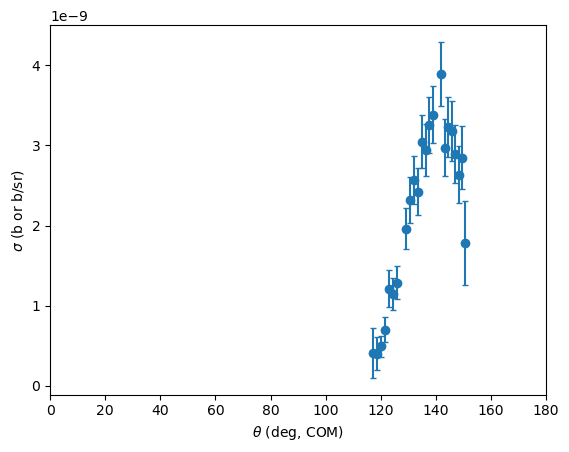

In [2]:
# We now need to do a trick to get the data files
# 'azr.predict( theta0, dress_up=False )' returns the contents in 'AZUREOut_aa=*_R=*.out'
output = np.vstack( azr.predict( theta0, dress_up=False ) )

# Now we loop over the data files to take their order and length and cut the output
index, data = 0, { } # Here, data is a dictionary
for segment in azr.config.data.segments:
    data[segment.filename] = output[index:index+len(segment.values)]
    index += len(segment.values)

E_COM       = output[:, 0] # COM energy
A_COM       = output[:, 2] # COM anlge
y = output[:, 5] # cross section
sigma_y = output[:, 6] # uncertainty of cross section

# Take a look at the data
fig, ax = plt.subplots()
ax.errorbar(A_COM, y, yerr=sigma_y, linestyle='', capsize=2, fmt="o")
# ax.set_yscale('log')
ax.set_xlim(0, 180)
ax.set_xlabel(r'$\theta$ (deg, COM)')
ax.set_ylabel(r'$\sigma$ (b or b/sr)');

### Step 2
* Set up priors for each of the sampled parameters and a corresponding prior ($\ln\Pi$) function.

In [3]:
# priors = [
#     stats.uniform(-3,3),
#     stats.uniform(-0.1,0.1),
#     stats.uniform(0,1),
#     stats.uniform(0,3),
#     stats.uniform(0,1),
#     stats.uniform(0,1)
# ]

# priors = []
# for theta in theta0:
    # priors.append(stats.uniform(theta-0.5*np.abs(theta), np.abs(theta)))

mask = np.array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2]) # Widths of the Gaussians can be different.
priors = [stats.norm(mu, abs(mu) * mask[i]) for i, mu in enumerate(theta0)]


The prior function is
$$\Pi=P(\vec{\theta})=P(\theta_{0})P(\theta_{1})...P(\theta_{nd})$$
$$\ln\Pi=\ln P(\vec{\theta})=\ln\left[P(\theta_{0})P(\theta_{1})...P(\theta_{nd})\right]=\ln P(\theta_{0})+\ln P(\theta_{1})+...+\ln P(\theta_{nd})$$

In [4]:
def lnPi(theta):
    return np.sum([pi.logpdf(t) for (pi, t) in zip(priors, theta)])

In [5]:
aaa=azr.predict( theta0, dress_up=False, full_output=True)

### Step 3
* Set up a likelihood ($\ln\mathcal{L}$) function.

We'll assume that the data are random draws from uncorrelated Gaussian distributions centered at the $R$-matrix predictions. So, we have
$$
\mathcal{L} = \prod_i \frac{1}{\sqrt{2\pi}\sigma_i} e^{-\frac{1}{2}\left(\frac{y_i-\mu_i}{\sigma_i}\right)^2}~,
$$
where $y_i$ and $\sigma_i$ are the data points and uncertainties, respectively, and $\mu_i$ is the physical model prediction.

We work with $\ln{\mathcal{L}}$ to avoid the numerical difficulties of dealing with extremely small values. The product then becomes a sum,
$$
\ln{\mathcal{L}} = \sum_i \left[-\ln{(\sqrt{2\pi}\sigma_i)} - \frac{1}{2}\left(\frac{y_i-\mu_i}{\sigma_i}\right)^2\right]
$$

In [6]:
# To calculate the likelihood, we generate the prediction at theta and compare
# it to data. (Assumes data uncertainties are Gaussian and IID.)
# 
# Important Note: The data and uncertaintes returned by AZR have the normalization factor applied.
# Inside the argument to the exponential, that's exactly what we want.
# The pre-factor to the likelihood, however, must have the original, presumably unmodified, normalization.
def lnL(theta):
    output = azr.predict(theta)[0]
    mu = output.xs_com_fit
    y = output.xs_com_data
    sigma = output.xs_err_com_data
    return np.sum(-np.log(np.sqrt(2*np.pi)*sigma_y) - 0.5*((y - mu)/sigma)**2)

### Step 4
* Construct a posterior ($\ln\mathcal{P}$) function from the likelihood and prior functions.

The posterior function is 
$$\mathcal{P}=\Pi\times\mathcal{L}$$
$$\ln\mathcal{P}=\ln\left(\Pi\mathcal{L}\right)=\ln\Pi+\ln\mathcal{L}$$

In [7]:
def lnP(theta):
    lnpi = lnPi( theta )                        # Calculate the prior
    if not np.isfinite( lnpi ): 
        return -np.inf  # If the prior is not finite, return -inf
    lnl = lnL( theta )                          # Calculate the likelihood
    return lnl + lnpi

### Step 5
* Prepare the MCMC walker and sample the posterior ($\ln\mathcal{P}$) function with emcee.

In [8]:
nw = 2*nd # number of walkers = 2 * number of sampled parameters

# Each walker needs its own starting position. We'll take normally distributed
# random values centered at theta0.
p0 = np.zeros((nw, nd))
mask = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1]) # Widths of the Gaussians can be different.
for i in range(nw):
    mu = theta0
    sig = np.abs(theta0) * mask
    p0[i, :] = stats.norm(mu, sig).rvs()


# We'll store the chain in chain.h5. (See emcee Backends documentation.)
backend = emcee.backends.HDFBackend('chain.h5')
backend.reset(nw, nd)

nsteps = 1000 # How many saved steps should each walker make?
nthin = 1 # How often should the walker save a step? n_total = nsteps * nthin
nprocs = nw # How many Python processes do you want to allocate?

# For a stretch move
move = emcee.moves.StretchMove( )

# emcee allows the user to specify the way the ensemble generates proposals.
with Pool(processes=nprocs) as pool:
    sampler = emcee.EnsembleSampler(nw, nd, lnP, pool=pool, backend=backend, moves=[move])
    state = sampler.run_mcmc(p0, nsteps, thin_by=nthin, progress=True, tune=True)

100%|██████████| 1000/1000 [04:40<00:00,  3.57it/s]


### Done! 
Next, let's plot the results.

#### 1. Posterior function evolution

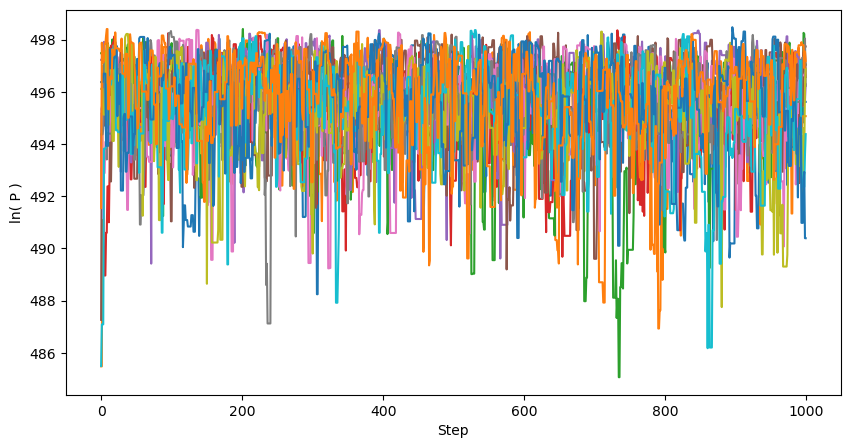

In [14]:
# Plot the probability
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

lnp = backend.get_log_prob()
ax.plot(lnp)

ax.set_xlabel('Step')
ax.set_ylabel('ln( P )')

plt.show()

#### 2. Parameters evolution

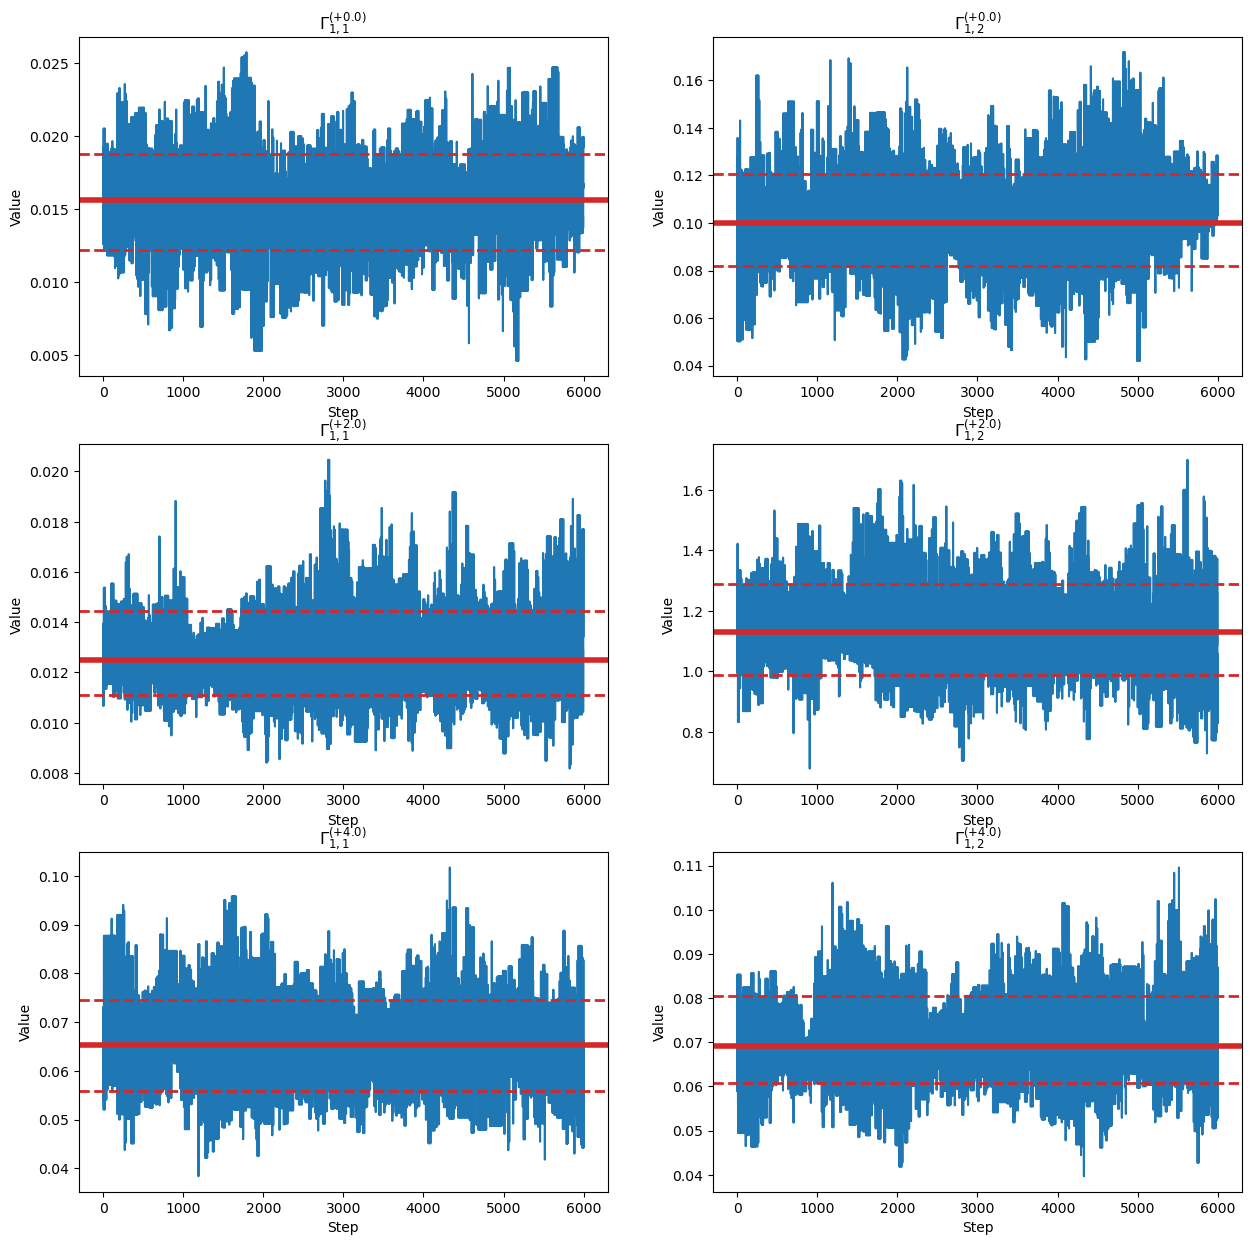

In [10]:
# Get the samples
nb=500 # discard the first nb samples
flat_samples = sampler.get_chain(flat=True, discard=nb)

# Plot the parameters
fig, ax = plt.subplots( int(nd / 2), 2, figsize=( 15, 15 ) )

means, lows, highs = [], [], []
final_results = np.zeros(6)
for i in range( nd ):

        mean = np.percentile( flat_samples[:,i], 50 )
        low = np.percentile( flat_samples[:,i], 16 )
        high = np.percentile( flat_samples[:,i], 84 )
    
        ax[i//2, i%2].set_title( azr.config.labels[i] )
        ax[i//2, i%2].set_xlabel( "Step" )

        ax[i//2, i%2].plot( flat_samples[:,i], color="tab:blue" )
        ax[i//2, i%2].axhline( mean, color="tab:red", linestyle="-", lw=4 )
        ax[i//2, i%2].axhline( low, color="tab:red", linestyle="--", lw=2 )
        ax[i//2, i%2].axhline( high, color="tab:red", linestyle="--", lw=2 )

        ax[i//2, i%2].set_ylabel( "Value" )

        means.append( mean )
        lows.append( low )
        highs.append( high )

# Save parameters to file
with open( "results/best-emcee.txt", "w" ) as f:
    for i in range( nd ):
        f.write( f"{azr.config.labels[i]}: {means[i]:.5f} + {highs[i]-means[i]:.5f} - {means[i]-lows[i]:.5f}\n" )

#### 3. Corner plot

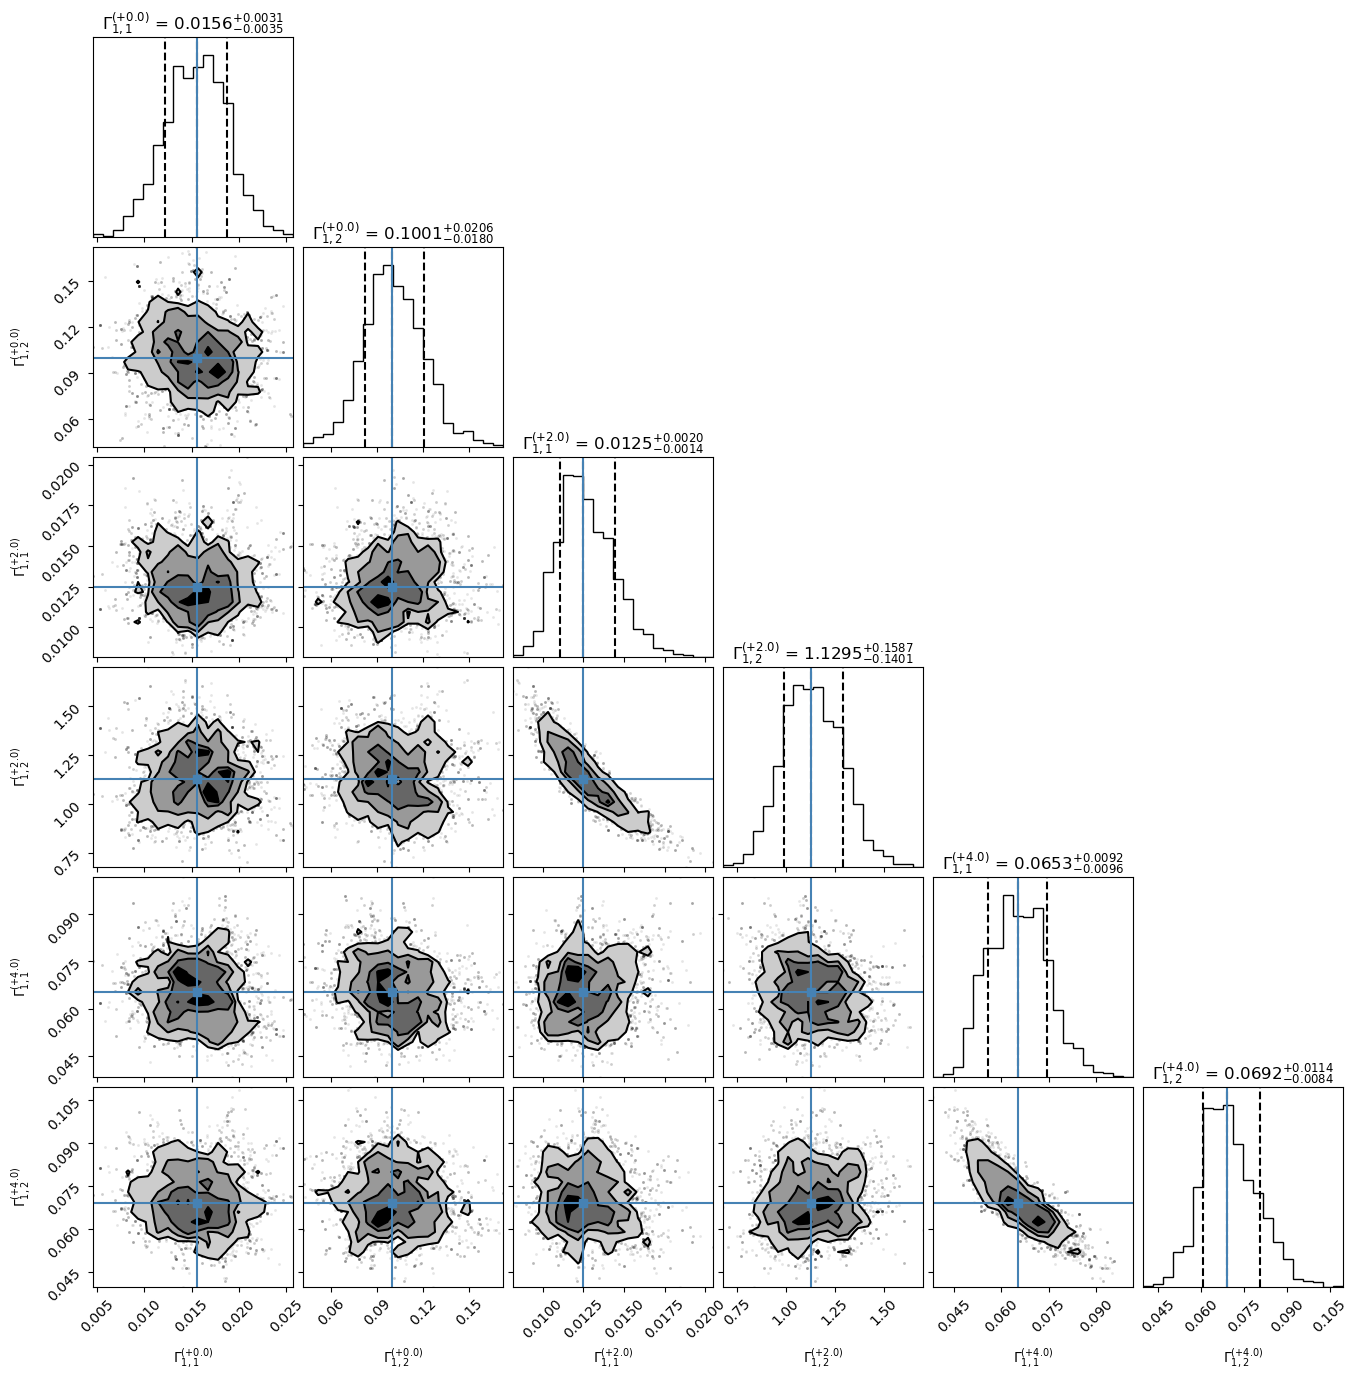

In [11]:
fig = corner.corner(
    flat_samples, labels=azr.config.labels, truths=means, quantiles=[0.16, 0.5, 0.84], title_fmt=".4f", fill_contours=True,
    show_titles=True,
);

#### 4. Resampling

In [12]:
# Buckets to store the resampled results
buckets = { "Differential" : [],
            "Angle_integrated" : []
           }

# We will sample only last 1000 samples for time reasons
np.random.shuffle( flat_samples )
for sample in tqdm( flat_samples[-1000:] ):
    result = azr.extrapolate(sample)[0]
    buckets["Differential"].append(result[:-1])
    buckets["Angle_integrated"].append(result[-1])

100%|██████████| 1000/1000 [01:27<00:00, 11.48it/s]


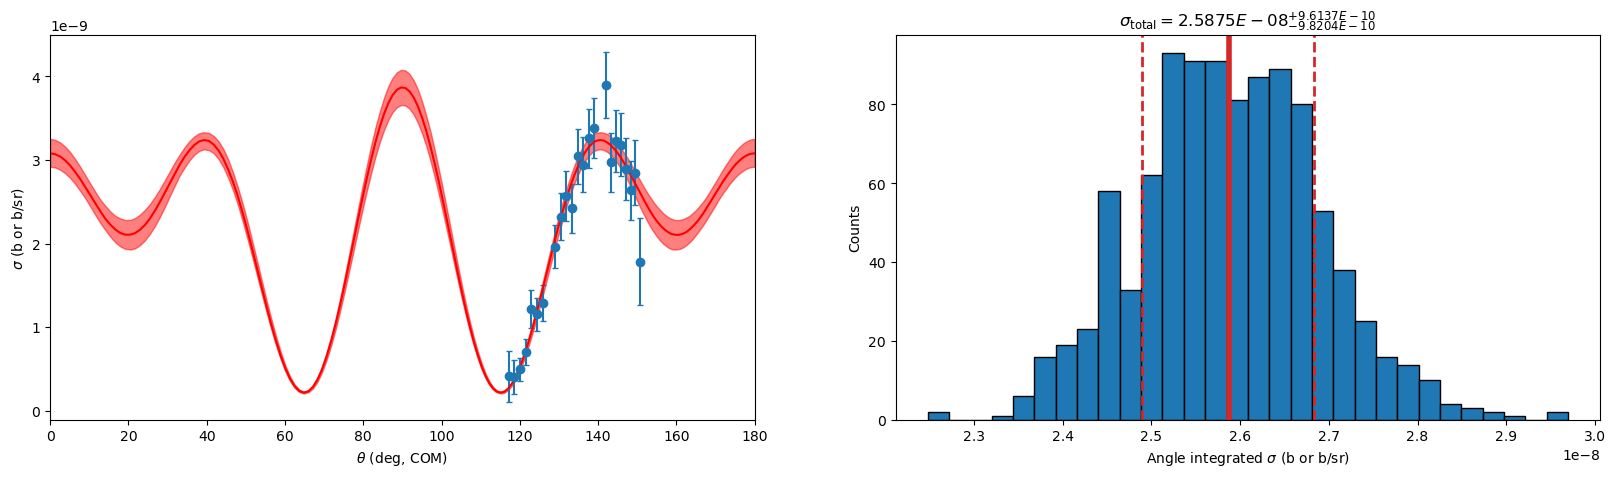

In [13]:
# Plot the reampled results and compared it to the data
fig, ax = plt.subplots( 1, 2, figsize=( 20, 5 ) )
for i, key in enumerate( buckets.keys( ) ):

    bucket = np.array( buckets[key] )

    if(key=="Differential"):
        ax[i%2].errorbar(A_COM, y, yerr=sigma_y, linestyle='', capsize=2, fmt="o")
        # ax[i%2].set_yscale('log')
        ax[i%2].set_xlim(0, 180)
        ax[i%2].set_xlabel(r'$\theta$ (deg, COM)')
        ax[i%2].set_ylabel(r'$\sigma$ (b or b/sr)');
        # Calculate the mean and deviation
        mean = np.percentile( bucket, 50, axis=0 )
        low = np.percentile(bucket, 16, axis=0)
        high = np.percentile(bucket, 84, axis=0)
        ax[i%2].plot( mean[:,2], mean[:,3], label="Extrapolation", color="red" )
        ax[i%2].fill_between( mean[:,2], low[:,3], high[:,3], color="red", alpha=0.5 )
        # ax[i%2].set_xlim(110, 160)

    if(key=="Angle_integrated"):
        ax[i%2].set_ylabel('Counts')
        ax[i%2].set_xlabel(r'Angle integrated $\sigma$ (b or b/sr)')
        ax[i%2].hist(bucket[:,3], bins=30, edgecolor='black')
        mean = np.percentile( bucket[:,3], 50 )
        low = np.percentile( bucket[:,3], 16 )
        high = np.percentile( bucket[:,3], 84 )
        ax[i%2].axvline( mean, color="tab:red", linestyle="-", lw=4 )
        ax[i%2].axvline( low, color="tab:red", linestyle="--", lw=2 )
        ax[i%2].axvline( high, color="tab:red", linestyle="--", lw=2 )
        q=np.diff([low, mean, high])
        ax[i%2].set_title(r'$\sigma_{\rm total} = %.4E_{-%.4E}^{+%.4E}$' % (mean, q[0], q[1]))
